## Preprocess PBMC Notebook
1. Perform Scanpy's Workflow for Processing PBMC Data (up until PCA)
2. Export resulting data as CSV.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from numpy.linalg import norm
import scanpy as sc

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [5]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

--2020-06-16 03:21:38--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 99.84.47.121, 99.84.47.10, 99.84.47.42, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|99.84.47.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  5.43MB/s    in 1.3s    

2020-06-16 03:21:39 (5.43 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’ saved [7621991/7621991]



In [2]:
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.4.3 numpy==1.18.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


In [6]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)   

In [7]:
adata.var_names_make_unique(join = '-')

In [8]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'gene_ids'

Only focus on genes that are highly expressed in the dataset.

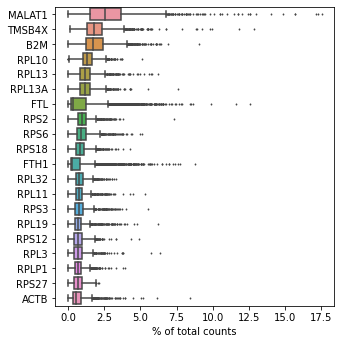

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [11]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714 
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

Remove (bad) observations with high numbers of mitochondrial genes. 

In [12]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)
#no log1p argument

In [13]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

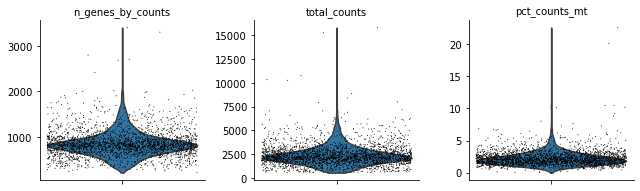

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

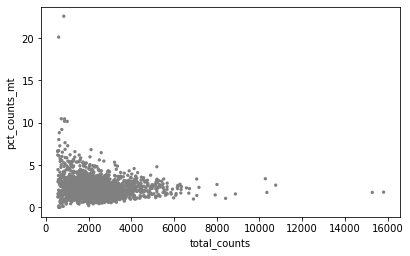

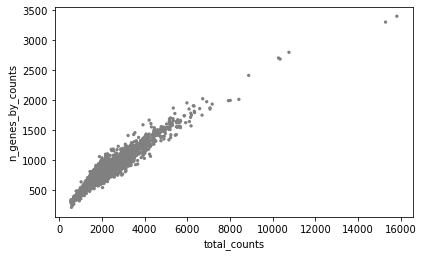

In [15]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [16]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [17]:
adata.X.data

array([1., 1., 2., ..., 1., 1., 3.], dtype=float32)

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [19]:
adata.X.data

array([ 4.1339397,  4.1339397,  8.2678795, ...,  5.0403223,  5.0403223,
       15.120967 ], dtype=float32)

In [20]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Apply a log transform to the data

In [21]:
sc.pp.log1p(adata)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [22]:
adata.X.data

array([1.6358733, 1.6358733, 2.2265546, ..., 1.7984574, 1.7984574,
       2.7801206], dtype=float32)

In [23]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [24]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

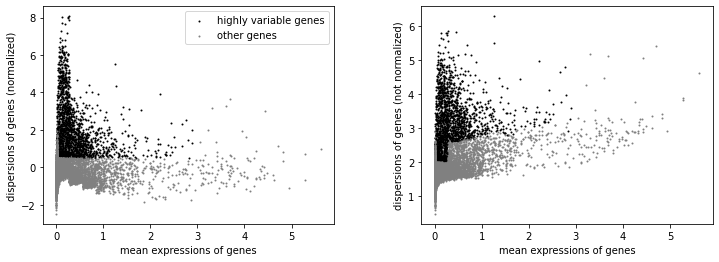

In [25]:
sc.pl.highly_variable_genes(adata)

In [26]:
adata.raw = adata

In [27]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

Include only highly variable genes

In [28]:
adata = adata[:, adata.var.highly_variable]

In [29]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [30]:
adata.X

<2638x1838 sparse matrix of type '<class 'numpy.float32'>'
	with 408743 stored elements in Compressed Sparse Row format>

In [31]:
adata.X.data

array([2.2265546, 1.6358733, 1.6358733, ..., 1.7984574, 1.7984574,
       1.7984574], dtype=float32)

Regress out effects from sequencing depth

In [32]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [33]:
adata.X

array([[-7.2785571e-02, -1.2929052e-01, -5.5762618e-03, ...,
        -1.7002191e-02, -8.3626725e-02, -4.0517688e-01],
       [-9.1086105e-02, -1.7157559e-01, -6.5472336e-03, ...,
        -4.6168588e-02, -1.2524137e-01, -4.5509979e-01],
       [-1.5998162e-01, -1.3586169e-01, -6.8725464e-03, ...,
        -2.7450195e-02, -6.8341322e-02,  1.0518360e+00],
       ...,
       [-8.7905586e-02, -1.1531777e-01, -5.5428366e-03, ...,
        -8.8488339e-03, -6.4416982e-02,  1.5571578e+00],
       [-8.0790803e-02, -1.0420774e-01, -5.2564032e-03, ...,
        -1.0238708e-03, -5.4077893e-02, -3.6773160e-01],
       [-1.4168720e-01, -1.1675589e-01, -6.2976936e-03, ...,
        -1.3568762e-02, -5.2123811e-02, -3.5951430e-01]], dtype=float32)

In [34]:
adata.X.shape

(2638, 1838)

Scale data to 0 mean and unit variance.

In [35]:
sc.pp.scale(adata, max_value=10)

In [ ]:
?

In [36]:
adata.X

array([[-0.17146961, -0.2808123 , -0.04667677, ..., -0.09826882,
        -0.20909512, -0.5312033 ],
       [-0.21458235, -0.37265328, -0.05480441, ..., -0.266844  ,
        -0.31314582, -0.5966543 ],
       [-0.3768877 , -0.29508454, -0.05752748, ..., -0.15865593,
        -0.17087644,  1.3789997 ],
       ...,
       [-0.20708963, -0.2504642 , -0.04639699, ..., -0.05114426,
        -0.16106427,  2.041497  ],
       [-0.1903285 , -0.2263338 , -0.04399936, ..., -0.00591774,
        -0.13521305, -0.48211104],
       [-0.33378935, -0.25358772, -0.05271561, ..., -0.07842438,
        -0.13032718, -0.47133783]], dtype=float32)

In [37]:
?adata.write

In [38]:
adata.write('pbmc_preprocess.h5ad')

In [36]:
#sc.read will retrieve the adata object